In [1]:
%load_ext autoreload
%autoreload 2

# Train DPT

If there is no `results` directory, run

In [5]:
# !bash dpt_run.sh

If there is, run

In [16]:
!python3 solvers/dpt/train_dpt.py

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anabatsheva (anabatsheva_sk). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.5
wandb: Run data is saved locally in /home/j/Desktop/GreyBoxDPTOptimizer_/wandb/run-20241108_143408-pa4nrk0w
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run denim-tree-49
wandb: ⭐️ View project at https://wandb.ai/anabatsheva_sk/GreyBoxDPT
wandb: 🚀 View run at https://wandb.ai/anabatsheva_sk/GreyBoxDPT/runs/pa4nrk0w
Loading training histories...
Num histories: 6000
Checkpoints path: ../GreyBoxDPTOptimizerData/checkpoints
Parameters: 51986
Training: 10001it [01:45, 94.50it/s]
wandb: 🚀 View run denim-tree-49 at: https://wandb.ai/anabatsheva_sk/GreyBoxDPT/runs/pa4nrk0w
wandb: Find logs at: wandb/run-20241108_143408-pa4nrk0w/logs


# Test DPT

Get a model

In [22]:
import torch
from solvers.dpt.src.model_dpt import DPT_K2D

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model = DPT_K2D(
    num_states=1,
    num_actions=16,
    hidden_dim=32,
    seq_len=50,
    num_layers=4,
    num_heads=4,
    attention_dropout=0.5,
    residual_dropout=0.1,
    embedding_dropout=0.3,
    normalize_qk=False,
    pre_norm=True,
    rnn_weights_path=None,
    state_rnn_embedding=1,
    rnn_dropout=0.0,
).to(DEVICE)

checkpoint_path = "../GreyBoxDPTOptimizerData/checkpoints/model_last.pt"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model.load_state_dict(checkpoint)
model.eval()

DPT_K2D(
  (embedd): Linear(in_features=1, out_features=1, bias=True)
  (embed_transition): Linear(in_features=19, out_features=32, bias=True)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
      (attention): CausalSelfAttentionWithCache(
        (in_proj): Linear(in_features=32, out_features=96, bias=True)
        (out_proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=32, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (action_head): Linear(in_features=32, out_features=16, bias=True)
)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [67]:
len(logits)

10

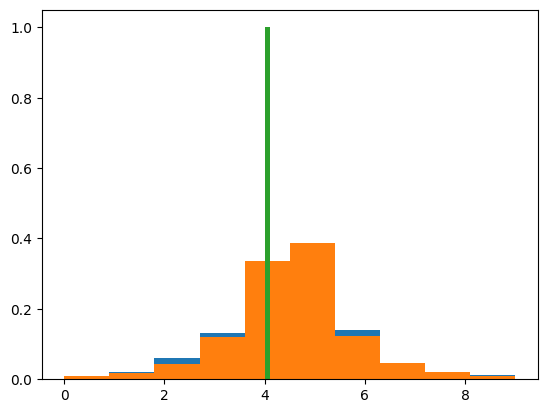

In [83]:
logits = torch.tensor(np.hstack([np.arange(5), np.arange(5)[::-1]])).to(torch.float)
temp = 0.5

# 1
probs = torch.nn.functional.softmax(logits, dim=-1)
N = 1000
next_tokens = torch.multinomial(probs, num_samples=N, replacement=True)#.squeeze(1)
plt.hist(next_tokens, bins=len(logits), density=True)

# 2
next_tokens = torch.multinomial(probs / temp, num_samples=N, replacement=True)#.squeeze(1)
plt.hist(next_tokens, bins=len(logits), density=True)

# 3
next_tokens = torch.argmax(logits, dim=-1)
plt.hist([next_tokens], bins=len(logits), density=False)

plt.show()

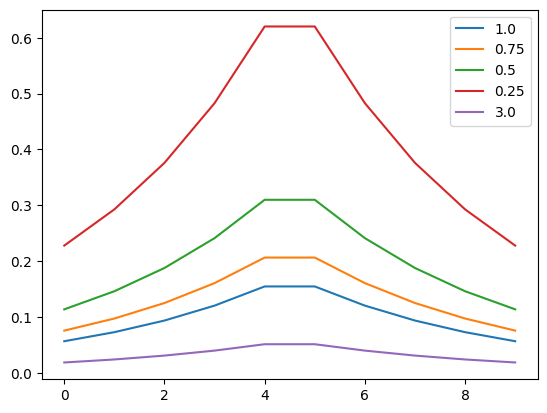

In [51]:
a = np.hstack([np.arange(5), np.arange(5)[::-1]]) / 4
plt.plot(softmax(a), label='1.0')
plt.plot(softmax(a) / 0.75, label='0.75')
plt.plot(softmax(a) / 0.5, label='0.5')
plt.plot(softmax(a) / 0.25, label='0.25')

plt.plot(softmax(a) / 3, label='3.0')

plt.legend()

Run it on a proble, of the class `Net`

In [26]:
import numpy as np
from torch.nn import functional as F
from utils import int2bin
from problems import Net
from utils import get_xaxis


p = Net(d=4, n=2, seed=1)
all_targets = p.target(get_xaxis(d=4, n=2))

query_states = torch.tensor([all_targets.max()])
context_states = torch.Tensor(1, 0)
context_next_states = torch.Tensor(1, 0)
context_actions = torch.Tensor(1, 0)
context_rewards = torch.Tensor(1, 0)

for _ in range(10):
    predicted_actions = model(
        query_states=query_states.to(dtype=torch.float, device=DEVICE),
        context_states=context_states.to(dtype=torch.float, device=DEVICE),
        context_next_states=context_next_states.to(dtype=torch.float, device=DEVICE),
        context_actions=context_actions.to(dtype=torch.long, device=DEVICE),
        context_rewards=context_rewards.to(dtype=torch.float, device=DEVICE),
    )
    predicted_action = torch.argmax(F.softmax(predicted_actions, dim=1)).cpu()
    # делать сэмплирование из распределения, а не брать моду
    # добавить температуру
    point = int2bin(predicted_action, d=4, n=2)
    target = torch.tensor(p.target(point))
    print(f'step {_} | current target: {query_states.item():>8.6} -> suggested point: {point} -> new target: {target.item():.6}')

    context_states = torch.cat([context_states, query_states.unsqueeze(0)], dim=1)
    context_next_states = torch.cat([context_next_states, target.unsqueeze(0)], dim=1)
    context_actions = torch.cat([context_actions, torch.tensor([predicted_action]).unsqueeze(0)], dim=1)
    context_rewards = torch.cat([context_rewards, (target - query_states).unsqueeze(0)], dim=1)
    query_states = target

print()
print(f'found minimal value: {target.item():.6}')
print(f'ground truth: {all_targets.min().item():.6}')
print()
print(f'all possible targets in an order:\n{np.sort(all_targets)}')

step 0 | current target: 0.898736 -> suggested point: [1 1 1 0] -> new target: 0.656192
step 1 | current target: 0.656192 -> suggested point: [1 1 1 0] -> new target: 0.656192
step 2 | current target: 0.656192 -> suggested point: [1 1 1 0] -> new target: 0.656192
step 3 | current target: 0.656192 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 4 | current target: 0.448428 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 5 | current target: 0.448428 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 6 | current target: 0.448428 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 7 | current target: 0.448428 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 8 | current target: 0.448428 -> suggested point: [1 0 1 0] -> new target: 0.448428
step 9 | current target: 0.448428 -> suggested point: [1 1 1 0] -> new target: 0.656192

found minimal value: 0.656192
ground truth: 0.136233

all possible targets in an order:
[0.13623276 0.22748694 0.343997

# Extra

other extra things

## Offline Test

In [ ]:
# # dataset = MarkovianDataset("trajectories/", seq_len=200)
# # dataloader = DataLoader(dataset=dataset, batch_size=1, pin_memory=True, shuffle=False, num_workers=0)

# for batch in dataloader:
#     (
#         query_flag,
#         query_states,
#         flags,
#         states,
#         actions,
#         next_flags,
#         next_states,
#         rewards,
#         target_actions,
#     ) = [b.to(dtype=torch.float, device=DEVICE) for b in batch]
#     break

# actions = actions.to(torch.long)

# predicted_actions = model(
#     query_states=query_states,
#     context_states=states,
#     context_next_states=next_states,
#     context_actions=actions,
#     context_rewards=rewards,
# )

# predicted_action = torch.argmax(F.softmax(predicted_actions, dim=1))
# target_actions, predicted_action

## Train step

In [ ]:
for i in range(2):
    print(f"Problem {i}...")
    !bash ./run.sh $i

In [ ]:
from solvers.dpt.src.utils.data import results2trajectories

results2trajectories('results', 'solvers/dpt/trajectories')

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F

from solvers.dpt.src.utils.data import MarkovianDataset
from solvers.dpt.src.model_dpt import DPT_K2D

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


dataset = MarkovianDataset('solvers/dpt/trajectories', seq_len=50)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=4,
    pin_memory=True,
    shuffle=False,
    num_workers=0,
)

In [ ]:
model = DPT_K2D(
    num_states=1,
    num_actions=16,
    hidden_dim=512,
    seq_len=50,
    num_layers=4,
    num_heads=4,
    attention_dropout=0.5,
    residual_dropout=0.1,
    embedding_dropout=0.3,
    normalize_qk=False,
    pre_norm=True,
    rnn_weights_path=None,
    state_rnn_embedding=16,
    rnn_dropout=0.0,
).to(DEVICE)

In [ ]:
for batch in dataloader:
    (
        query_states,
        states,
        actions,
        next_states,
        rewards,
        target_actions,
    ) = [b.to(DEVICE) for b in batch]
    break

In [ ]:
query_states = query_states.to(torch.float)
states = states.to(torch.float)
actions = actions.to(torch.long)
next_states = next_states.to(torch.float)
rewards = rewards.to(torch.float32)

In [ ]:
target_actions_onehot = (
    F.one_hot(target_actions.squeeze(-1), num_classes=16)
    .unsqueeze(1)
    .repeat(1, 50, 1)
    .float()
)

In [ ]:
predicted_actions = model(
    query_states=query_states,
    context_states=states,
    context_next_states=next_states,
    context_actions=actions,
    context_rewards=rewards,
)
predicted_actions = predicted_actions[:, 1:, :]

In [ ]:
loss = F.cross_entropy(
    input=predicted_actions.flatten(0, 1),
    target=target_actions_onehot.flatten(0, 1),
    label_smoothing=0.0,
)

In [ ]:
loss